# 1. Setup

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
# Import uuid library to generate unique image names
import uuid

In [5]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\381250d8-709b-11ed-a68f-bc6ee2c777b7.jpg'

In [57]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(4)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [58]:
plt.imshow(frame[120:120+250,200:200+250, :])

NameError: name 'frame' is not defined

# 2.x NEW - Data Augmentation

In [6]:
import os
import uuid

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(400)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(400)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(400)

In [8]:
dir_test = anchor.as_numpy_iterator()

In [9]:
print(dir_test.next())

b'data\\anchor\\1c58b659-5e59-11ed-a412-bc6ee2c777ba.jpg'


In [10]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [11]:
img = preprocess('data\\anchor\\1ac90853-5e59-11ed-81d3-bc6ee2c777ba.jpg')

In [12]:
img.numpy().max() 

0.83112746

In [13]:
img.numpy().min() 

0.0

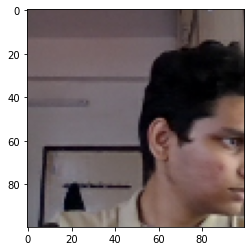

In [14]:
plt.imshow(img)

In [15]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [16]:
samples = data.as_numpy_iterator()

In [17]:
exampple = samples.next()

In [18]:
exampple

(b'data\\anchor\\22acf423-5e59-11ed-93d3-bc6ee2c777ba.jpg',
 b'data\\positive\\2437aaf9-5f95-11ed-a00f-bc6ee2c777ba.jpg',
 1.0)

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_twin(*exampple)

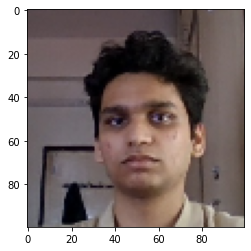

In [21]:
plt.imshow(res[0])

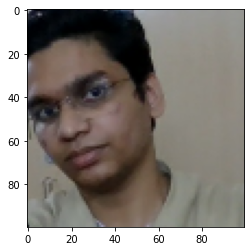

In [22]:
plt.imshow(res[1])

In [23]:
res[2]

1.0

In [24]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [25]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [26]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [27]:
inp = Input(shape=(100,100,3), name='input_image')

In [28]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [29]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [30]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [31]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [32]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [33]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [34]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [35]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [36]:
embedding = make_embedding()

In [37]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2 Build Distance Layer

In [38]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [39]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [40]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [41]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [42]:
siamese_layer = L1Dist()

In [43]:
distances = siamese_layer(inp_embedding, val_embedding)

In [44]:
classifier = Dense(1, activation='sigmoid')(distances)

In [45]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [46]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [47]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [48]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [49]:
siamese_model = make_siamese_model()

In [50]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [51]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [53]:
test_batch = train_data.as_numpy_iterator()

In [54]:
batch_1 = test_batch.next()

In [55]:
X = batch_1[:2]

In [56]:
y = batch_1[2]

In [57]:
y

array([1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1.],
      dtype=float32)

In [58]:
tf.losses.BinaryCrossentropy??

In [59]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [60]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [61]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        

## 5.5 Train the model

In [64]:
EPOCHS = 50

In [72]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
33/35 [===========================>..] - ETA: 1:17

KeyboardInterrupt: 

# 6. Evaluate Model

## 6.1 Import Metrics

In [62]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [63]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [64]:
y_hat = siamese_model.predict([test_input, test_val])

In [65]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]

In [69]:
y_true

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [70]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [71]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.33333334

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

## 6.4 Viz Results

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [237]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [126]:
L1Dist

__main__.L1Dist

In [66]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [67]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[1.6696612e-08],
       [1.0000000e+00],
       [4.2342991e-12],
       [1.4299242e-07],
       [1.2427880e-12],
       [2.5459523e-09],
       [9.9999857e-01],
       [1.8319321e-08],
       [1.0000000e+00],
       [3.8711114e-09],
       [1.0546174e-09],
       [1.0878356e-12],
       [9.9999982e-01],
       [9.9999875e-01],
       [1.4200295e-11],
       [8.9284358e-06]], dtype=float32)

In [68]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

## 8.1 Verification Function

In [69]:
os.listdir(os.path.join('application_data', 'verification_images'))

['c0229946-5e58-11ed-874a-bc6ee2c777ba.jpg',
 'c07762dd-5e58-11ed-b148-bc6ee2c777ba.jpg',
 'c0845bc4-5e58-11ed-8079-bc6ee2c777ba.jpg',
 'c140b474-5e58-11ed-9a1b-bc6ee2c777ba.jpg',
 'c15497c6-5e58-11ed-9046-bc6ee2c777ba.jpg',
 'c1739e42-5e58-11ed-aa42-bc6ee2c777ba.jpg',
 'c1825fd8-5e58-11ed-bb64-bc6ee2c777ba.jpg',
 'c192c7c9-5e58-11ed-8b9b-bc6ee2c777ba.jpg',
 'c234aeba-5e58-11ed-a2a1-bc6ee2c777ba.jpg',
 'c246ae0d-5e58-11ed-862b-bc6ee2c777ba.jpg',
 'c250f347-5e58-11ed-8988-bc6ee2c777ba.jpg',
 'c33369d6-5e58-11ed-bec7-bc6ee2c777ba.jpg',
 'c366aa88-5e58-11ed-b991-bc6ee2c777ba.jpg',
 'c4493d23-5e58-11ed-821e-bc6ee2c777ba.jpg',
 'c4537c03-5e58-11ed-9af6-bc6ee2c777ba.jpg',
 'c464dfd8-5e58-11ed-94be-bc6ee2c777ba.jpg',
 'c492abb2-5e58-11ed-b0cd-bc6ee2c777ba.jpg',
 'c50331a5-5e58-11ed-ba8f-bc6ee2c777ba.jpg',
 'c52e5f62-5e58-11ed-aa15-bc6ee2c777ba.jpg',
 'c5431cac-5e58-11ed-a7f0-bc6ee2c777ba.jpg',
 'c56f7535-5e58-11ed-8acd-bc6ee2c777ba.jpg',
 'c58e60fe-5e58-11ed-a2c8-bc6ee2c777ba.jpg',
 'c597f579

In [70]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [71]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\c0229946-5e58-11ed-874a-bc6ee2c777ba.jpg
application_data\verification_images\c07762dd-5e58-11ed-b148-bc6ee2c777ba.jpg
application_data\verification_images\c0845bc4-5e58-11ed-8079-bc6ee2c777ba.jpg
application_data\verification_images\c140b474-5e58-11ed-9a1b-bc6ee2c777ba.jpg
application_data\verification_images\c15497c6-5e58-11ed-9046-bc6ee2c777ba.jpg
application_data\verification_images\c1739e42-5e58-11ed-aa42-bc6ee2c777ba.jpg
application_data\verification_images\c1825fd8-5e58-11ed-bb64-bc6ee2c777ba.jpg
application_data\verification_images\c192c7c9-5e58-11ed-8b9b-bc6ee2c777ba.jpg
application_data\verification_images\c234aeba-5e58-11ed-a2a1-bc6ee2c777ba.jpg
application_data\verification_images\c246ae0d-5e58-11ed-862b-bc6ee2c777ba.jpg
application_data\verification_images\c250f347-5e58-11ed-8988-bc6ee2c777ba.jpg
application_data\verification_images\c33369d6-5e58-11ed-bec7-bc6ee2c777ba.jpg
application_data\verification_images\c366aa88-5e58-11ed-b991-bc6

In [72]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)qqqqqqqq

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [17]:
np.sum(np.squeeze(results) > 0.9)

36

In [18]:
results

[array([[0.9944859]], dtype=float32),
 array([[0.9999912]], dtype=float32),
 array([[0.9999943]], dtype=float32),
 array([[0.9999951]], dtype=float32),
 array([[0.99993753]], dtype=float32),
 array([[0.9082498]], dtype=float32),
 array([[0.9999846]], dtype=float32),
 array([[0.9834683]], dtype=float32),
 array([[0.87159216]], dtype=float32),
 array([[0.7328309]], dtype=float32),
 array([[0.74533516]], dtype=float32),
 array([[0.949607]], dtype=float32),
 array([[0.7501703]], dtype=float32),
 array([[0.60669833]], dtype=float32),
 array([[0.93921214]], dtype=float32),
 array([[0.9813106]], dtype=float32),
 array([[0.9848625]], dtype=float32),
 array([[0.89696234]], dtype=float32),
 array([[0.98896575]], dtype=float32),
 array([[0.99082947]], dtype=float32),
 array([[0.7747197]], dtype=float32),
 array([[0.99999297]], dtype=float32),
 array([[0.99986887]], dtype=float32),
 array([[0.9999764]], dtype=float32),
 array([[0.90808266]], dtype=float32),
 array([[0.8795649]], dtype=float32),
 a